In [1]:
import zipfile
import os

zip_path = '/content/images_256.zip'
extract_path = '/content'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Setup Code
Import required libraries & data

In [2]:
import os
import copy
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image

In [3]:
BATCH_SIZE = 64
N_EPOCHS = 50
IMAGE_FOLDER = 'images_256'
IMAGE_SIZE = 256

In [4]:
to_id_map = {
    "['N']": 0,
    "['D']": 1,
    "['G']": 2,
    "['C']": 3,
    "['A']": 4,
    "['H']": 5,
    "['M']": 6,
    "['O']": 7
}

to_name_map = {
    "['N']": "Normal (N)",
    "['D']": "Diabetes (D)",
    "['G']": "Glaucoma (G)",
    "['C']": "Cataract (C)",
    "['A']": "AMD (A)",
    "['H']": "Hypertension (H)",
    "['M']": "Myopia (M)",
    "['O']": "Other (O)"
}

id_to_name_map = {v: to_name_map[k] for k, v in to_id_map.items()}

# Data Visualization & Preprocessing

In [5]:
raw_df = pd.read_csv('label_images.csv')
raw_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,label,target,images
0,0.0,69.0,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1.0,57.0,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2.0,42.0,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4.0,53.0,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5.0,50.0,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
describe_df = raw_df[['ID', 'label', 'images']]
describe_df.describe(include='all')

,ID,label,images
count,6392.000000,9868,9868
unique,NaN,8,9868
top,NaN,['N'],NEWOTHER_EXTRA_DATA993.png
freq,NaN,3230,1
mean,2271.150814,NaN,NaN
std,1417.559018,NaN,NaN
min,0.000000,NaN,NaN
25%,920.750000,NaN,NaN
50%,2419.500000,NaN,NaN
75%,3294.000000,NaN,NaN


In [6]:
# Dataset Class
class RetinalDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        """
        Args:
            df (pd.DataFrame): The dataframe containing 'images' and 'label' columns
            image_folder (string): Directory with all the images.
            transform (callable, optional): transformations to apply (resize, etc.)
        """
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. FIND THE IMAGE
        img_name = self.df.iloc[idx]['images']
        img_path = os.path.join(self.image_folder, img_name)

        # 2. OPEN THE IMAGE
        # convert('RGB') ensures 3 channels (R, G, B)
        image = Image.open(img_path).convert('RGB')

        # 3. GET THE LABEL
        label_str = self.df.iloc[idx]['label']

        # Map string label to integer. Default to 7 (Other) if unexpected.
        label_id = to_id_map.get(label_str, 7)

        # 4. APPLY TRANSFORMATIONS
        if self.transform:
            image = self.transform(image)

        # 5. RETURN TENSOR PAIR
        return image, torch.tensor(label_id, dtype=torch.long)

In [7]:
# Train-Test-Val Split
train_df, temp_df = train_test_split(raw_df, test_size=0.25, random_state=42, stratify=raw_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train size: {len(train_df)} (Used for training)")
print(f"Val size:   {len(val_df)}   (Used for early stopping)")
print(f"Test size:  {len(test_df)}  (Used for final score)")

Train size: 7401 (Used for training)
Val size:   1233   (Used for early stopping)
Test size:  1234  (Used for final score)


In [8]:
# Define Sampler
# Count samples per class in the training set
class_counts = train_df['label'].value_counts().sort_index()

# Calculate weight: 1 / count
# (Rare classes get higher weights, common classes get lower weights)
class_weights = 1.0 / class_counts

# Convert to dictionary for mapping: {'['N']': 0.00044, ...}
weight_map = class_weights.to_dict()

# Map these weights to every single sample in the dataframe
sample_weights = train_df['label'].map(weight_map).values

# Convert to DoubleTensor (required by Sampler)
sample_weights = torch.DoubleTensor(sample_weights)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [9]:
# Define Tranforms w/ Data Augmentation

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def denormalize(tensor):
    """
    Reverses the normalization on a tensor image so it looks normal to humans.
    """
    # Clone the tensor so we don't mess up the actual data for the model
    img = tensor.clone().cpu().numpy()

    # Switch from (Channels, Height, Width) -> (Height, Width, Channels)
    img = img.transpose(1, 2, 0)

    # Reverse the math: (Value * Std) + Mean
    img = img * std + mean

    # Force values to stay between 0 and 1 (removes the "Clipping" warning)
    img = np.clip(img, 0, 1)
    return img

In [10]:
# Initialize
train_ds = RetinalDataset(train_df, IMAGE_FOLDER, transform=train_transforms)
val_ds   = RetinalDataset(val_df,   IMAGE_FOLDER, transform=data_transform)
test_ds  = RetinalDataset(test_df,  IMAGE_FOLDER, transform=data_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

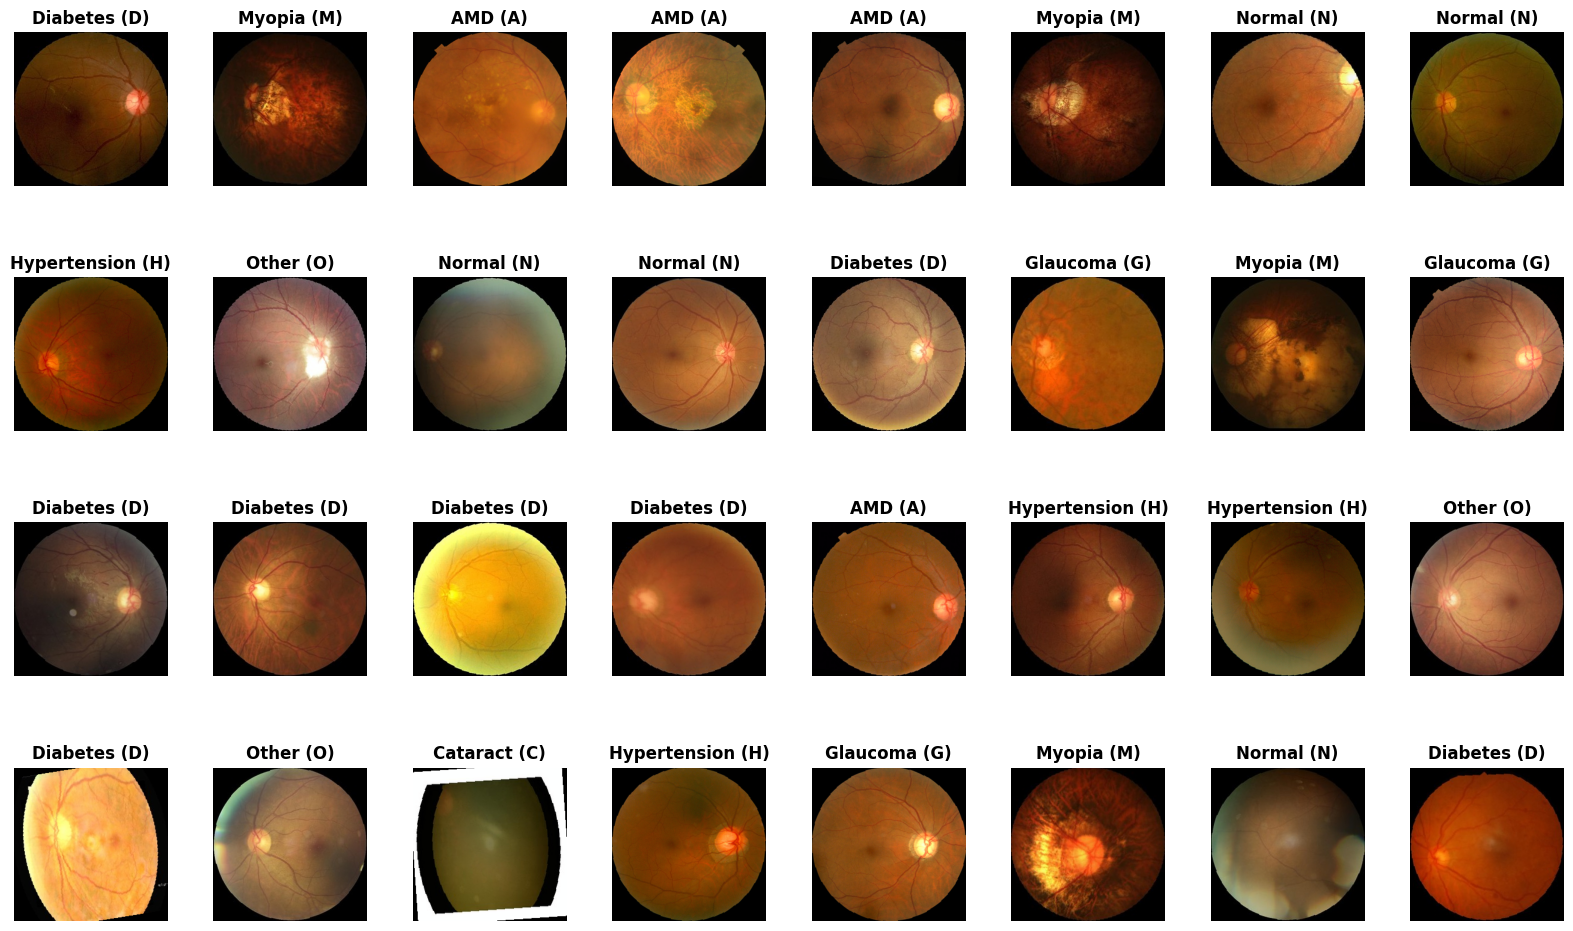

In [ ]:
# Data Visualization
sns.set_style('darkgrid')
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(4, 8, figsize = (20,12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()
for i in range(32):
    img = denormalize(images[i])
    label_id = labels[i].item()
    label_name = id_to_name_map.get(label_id)
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(label_name, fontsize=12, color='black', fontweight='bold')
    ax.axis('off')

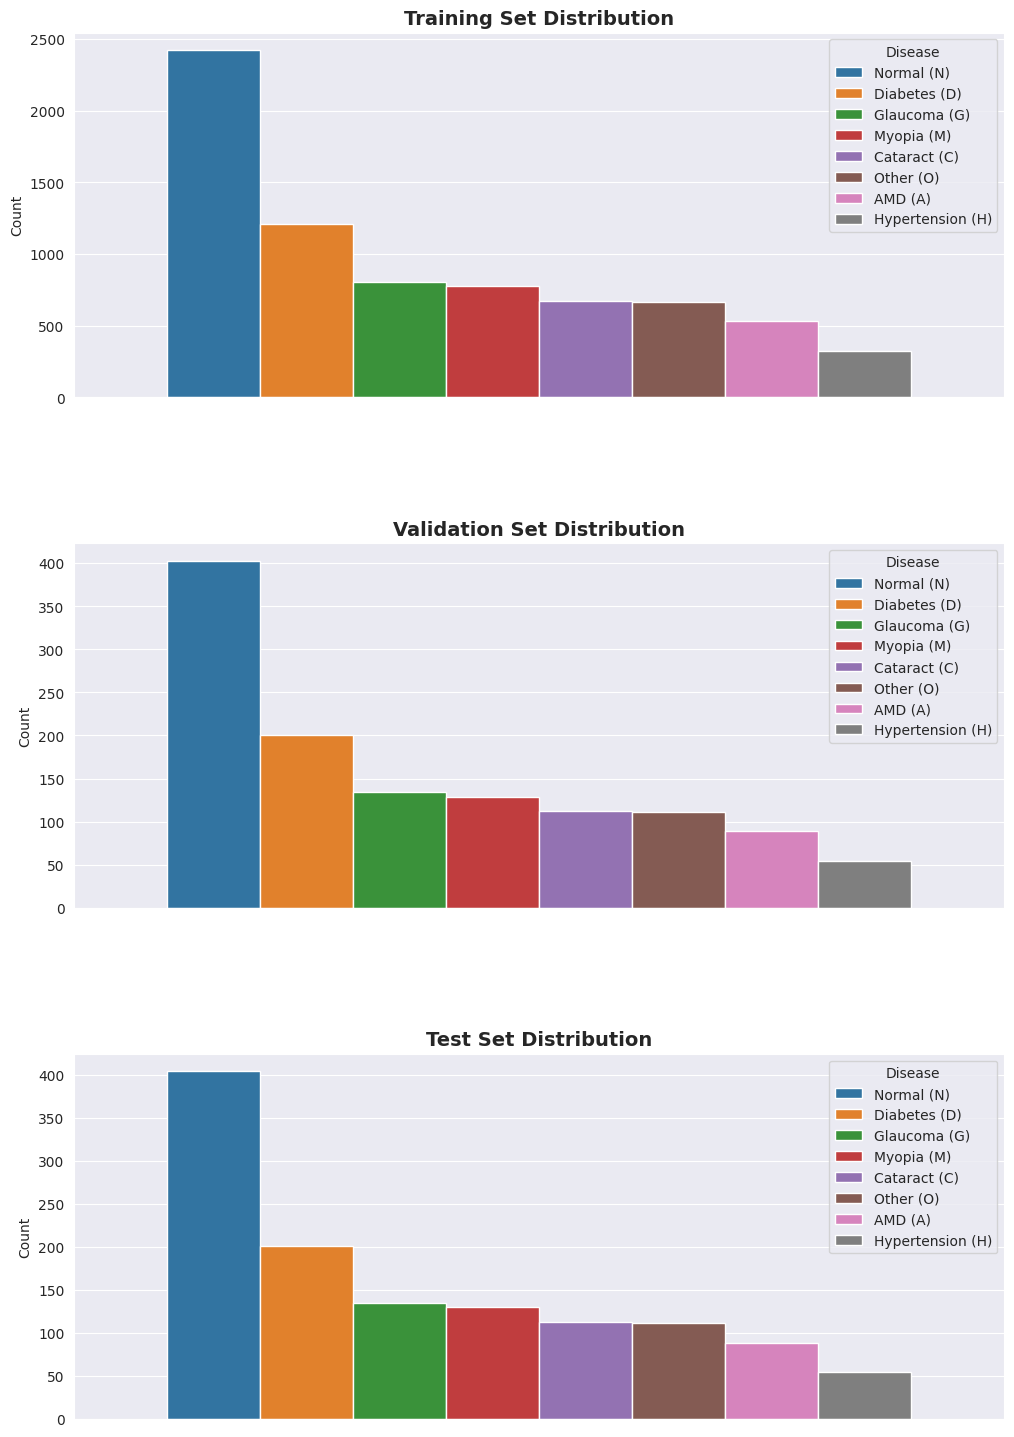

In [ ]:
# Counts of Labels in Each Dataset
def get_label_distribution(dataset):
    """
    Counts samples per label in the RetinalDataset.
    Accesses dataset.df directly instead of .targets
    """
    counts = dataset.df['label'].value_counts().to_dict()

    clean_counts = {}
    for key, value in counts.items():
        cleaned_name = to_name_map.get(key)
        clean_counts[cleaned_name] = value

    return clean_counts

def plot_from_dict(data_dict, plot_title, ax):
    df = pd.DataFrame(list(data_dict.items()), columns=['Disease', 'Count'])
    sns.barplot(data=df, hue='Disease', y='Count', ax=ax)
    ax.set_title(plot_title, fontsize=14, fontweight='bold')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
plt.subplots_adjust(hspace=0.4)

plot_from_dict(get_label_distribution(train_ds), "Training Set Distribution", ax=axes[0])
plot_from_dict(get_label_distribution(val_ds),   "Validation Set Distribution", ax=axes[1])
plot_from_dict(get_label_distribution(test_ds),  "Test Set Distribution", ax=axes[2])

plt.show()

NameError: name 'ax' is not defined

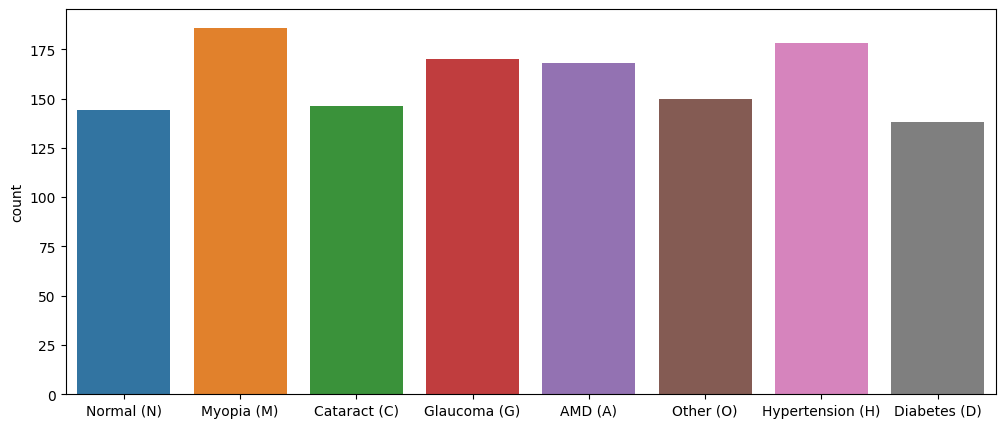

In [ ]:
# Visualize Sampler
all_labels=[]
for i, (_, labels) in enumerate(train_loader):
    if i >= 20: break
    all_labels.extend(labels.tolist())

    class_names = [id_to_name_map.get(x) for x in all_labels]

plt.figure(figsize=(12, 5))
ax = sns.countplot(x=class_names, hue=class_names, legend=False)
ax.set_title("Training Set Distribution /w Sampler", fontsize=14, fontweight='bold')
plt.show()


# Model Building

In [13]:
class ClassificationCnn(nn.Module):
    """
    A custom Convolutional Neural Network (CNN) for Retinal Disease Classification.
    Architecture Style: VGG-like (Sequential Convolutional Blocks)
    Input Expectation: Images of size (Batch_Size, 3, 256, 256)
    """
    def __init__(self, num_class):
        super(ClassificationCnn, self).__init__()
        self.num_class = num_class

        # 4 blocks to detect patterns.
        # Each reduces image size by half, doubles the number of "filters".
        self.conv = nn.Sequential(
            # Block 1
            # Input: (3, 256, 256) -> Output: (16, 128, 128)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            # Input: (16, 128, 128) -> Output: (32, 64, 64)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            # Input: (32, 64, 64) -> Output: (64, 32, 32)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            # Input: (64, 32, 32) -> Output: (128, 16, 16)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Takes the features found above and makes a decision.
        # Input Size: 128 channels * 6 width * 6 height
        self.fc = nn.Sequential(
            # Layer 1: Connection from feature maps to hidden neurons
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),

            # Dropout: Prevents the model from overfitting
            nn.Dropout(0.25),

            # Layer 2: Compress info further
            nn.Linear(256, 128),
            nn.ReLU(),

            # Output: Final decision scores for each class
            nn.Linear(128, self.num_class)
        )

    def forward(self, x):
        """
        Forward pass defines how data moves through the graph.
        """
        # Extract features
        x = self.conv(x)

        # Flatten: Turn (Batch, 128, 6, 6) -> (Batch, 128)
        x = x.view(x.size(0), -1)

        # Classify
        x = self.fc(x)
        return x

# Model Training

In [ ]:
# Initialize Model & Use Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassificationCnn(8).to(device)

# Summarize Model

summary(model, input_size=(3, 256, 256))

In [ ]:
# Class-Weighted Loss Function
# Get class weights from previously computed class_weights (inverse of class frequencies)
# Ensure the weights are in the same order as the to_id_map
class_weights_list = [class_weights[k] for k in to_id_map.keys()]
weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)

# Unused


In [ ]:
# Model Training

# Criterion: Measures how wrong the model is
criterion = nn.CrossEntropyLoss()

# Optimizer: Adjusts the weights based on the errors.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Scheduler: Lower learning_rate if no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Scoring for plotting
train_losses = np.zeros(N_EPOCHS)
val_losses = np.zeros(N_EPOCHS)

# Remember the best score
# Deepcopy creates snapshot of weights in memory
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Start timer for training duration
since = time.time()

for epoch in range(N_EPOCHS):

    # Training

    # Track corrects and loss per epoch to calculate averages
    train_corrects = 0
    train_loss = 0.0

    model.train()

    # Wrap with tqdm for progress bar
    for inputs, targets in tqdm(train_loader, desc=f'Training Epoch: {epoch + 1}/{N_EPOCHS}'):

        inputs, targets = inputs.to(device), targets.to(device)

        # Reset gradients for each batch
        optimizer.zero_grad()

        # Forward Pass: Ask model for prediction
        outputs = model(inputs)

        # Calculate Error: Compare predictions vs actual labels
        loss = criterion(outputs, targets)

        # Track Stats
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == targets.data)
        train_loss += loss.item() * inputs.size(0)

        # Backward Pass: Calculate how much each weight contributed to the error
        loss.backward()

        # Update Weights: Nudge parameters in the opposite direction of the gradient
        optimizer.step()

    # Calculate average loss/acc over the entire dataset
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)

    # Validation

    # Disable gradient calculation & dropout, lock batch norm
    with torch.no_grad():
        val_corrects = 0
        val_loss = 0.0
        model.eval()

        for inputs, targets in tqdm(val_loader, desc=f'Validating Epoch: {epoch + 1}/{N_EPOCHS}'):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Save copy of  performing weights
            best_model_wts = copy.deepcopy(model.state_dict())

    # save epoch losses
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss

    print(f"Epoch {epoch+1}/{N_EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print('-'*30)

# Print total training time
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Overwrite with best weights
model.load_state_dict(best_model_wts)

Validating Epoch: 1/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 1/50:
Train Loss: 1.7006, Train Accuracy: 0.3517
Validation Loss: 1.5510, Validation Accuracy: 0.3471
------------------------------


Validating Epoch: 2/50: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Epoch 2/50:
Train Loss: 1.4774, Train Accuracy: 0.4355
Validation Loss: 1.4525, Validation Accuracy: 0.4047
------------------------------


Validating Epoch: 3/50: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 3/50:
Train Loss: 1.3852, Train Accuracy: 0.4668
Validation Loss: 1.4139, Validation Accuracy: 0.4282
------------------------------


Validating Epoch: 4/50: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


Epoch 4/50:
Train Loss: 1.2650, Train Accuracy: 0.5122
Validation Loss: 1.3143, Validation Accuracy: 0.5142
------------------------------


Validating Epoch: 5/50: 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Epoch 5/50:
Train Loss: 1.2605, Train Accuracy: 0.5017
Validation Loss: 1.3079, Validation Accuracy: 0.4461
------------------------------


Validating Epoch: 6/50: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Epoch 6/50:
Train Loss: 1.1939, Train Accuracy: 0.5321
Validation Loss: 1.2872, Validation Accuracy: 0.4631
------------------------------


Validating Epoch: 7/50: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 7/50:
Train Loss: 1.1394, Train Accuracy: 0.5522
Validation Loss: 1.3111, Validation Accuracy: 0.4517
------------------------------


Validating Epoch: 8/50: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 8/50:
Train Loss: 1.1262, Train Accuracy: 0.5542
Validation Loss: 1.2015, Validation Accuracy: 0.5556
------------------------------


Validating Epoch: 9/50: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Epoch 9/50:
Train Loss: 1.0901, Train Accuracy: 0.5640
Validation Loss: 1.2007, Validation Accuracy: 0.4947
------------------------------


Validating Epoch: 10/50: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 10/50:
Train Loss: 1.0747, Train Accuracy: 0.5636
Validation Loss: 1.2068, Validation Accuracy: 0.4947
------------------------------


Validating Epoch: 11/50: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 11/50:
Train Loss: 1.0563, Train Accuracy: 0.5714
Validation Loss: 1.2509, Validation Accuracy: 0.4769
------------------------------


Validating Epoch: 12/50: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


Epoch 12/50:
Train Loss: 1.0293, Train Accuracy: 0.5855
Validation Loss: 1.1848, Validation Accuracy: 0.5109
------------------------------


Validating Epoch: 13/50: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Epoch 13/50:
Train Loss: 1.0173, Train Accuracy: 0.5895
Validation Loss: 1.1163, Validation Accuracy: 0.5499
------------------------------


Validating Epoch: 14/50: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Epoch 14/50:
Train Loss: 1.0199, Train Accuracy: 0.5937
Validation Loss: 1.1700, Validation Accuracy: 0.4988
------------------------------


Validating Epoch: 15/50: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch 15/50:
Train Loss: 0.9953, Train Accuracy: 0.6010
Validation Loss: 1.0968, Validation Accuracy: 0.5507
------------------------------


Validating Epoch: 16/50: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


Epoch 16/50:
Train Loss: 0.9737, Train Accuracy: 0.6045
Validation Loss: 1.1187, Validation Accuracy: 0.5004
------------------------------


Validating Epoch: 17/50: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Epoch 17/50:
Train Loss: 0.9580, Train Accuracy: 0.6087
Validation Loss: 1.1074, Validation Accuracy: 0.5109
------------------------------


Validating Epoch: 18/50: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Epoch 18/50:
Train Loss: 0.9651, Train Accuracy: 0.6046
Validation Loss: 1.1394, Validation Accuracy: 0.5150
------------------------------


Validating Epoch: 19/50: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


Epoch 19/50:
Train Loss: 0.9549, Train Accuracy: 0.6102
Validation Loss: 1.1929, Validation Accuracy: 0.4834
------------------------------


Validating Epoch: 20/50: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


Epoch 20/50:
Train Loss: 0.8507, Train Accuracy: 0.6479
Validation Loss: 1.0626, Validation Accuracy: 0.5296
------------------------------


Validating Epoch: 21/50: 100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


Epoch 21/50:
Train Loss: 0.8334, Train Accuracy: 0.6614
Validation Loss: 1.0693, Validation Accuracy: 0.5361
------------------------------


Validating Epoch: 22/50: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Epoch 22/50:
Train Loss: 0.8043, Train Accuracy: 0.6644
Validation Loss: 1.0734, Validation Accuracy: 0.5296
------------------------------


Validating Epoch: 23/50: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Epoch 23/50:
Train Loss: 0.8031, Train Accuracy: 0.6649
Validation Loss: 1.0537, Validation Accuracy: 0.5328
------------------------------


Validating Epoch: 24/50: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 24/50:
Train Loss: 0.7889, Train Accuracy: 0.6722
Validation Loss: 1.0365, Validation Accuracy: 0.5426
------------------------------


Validating Epoch: 25/50: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


Epoch 25/50:
Train Loss: 0.7735, Train Accuracy: 0.6763
Validation Loss: 1.0428, Validation Accuracy: 0.5426
------------------------------


Validating Epoch: 26/50: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Epoch 26/50:
Train Loss: 0.7774, Train Accuracy: 0.6642
Validation Loss: 1.0535, Validation Accuracy: 0.5264
------------------------------


Validating Epoch: 27/50: 100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


Epoch 27/50:
Train Loss: 0.7824, Train Accuracy: 0.6727
Validation Loss: 1.0411, Validation Accuracy: 0.5507
------------------------------


Validating Epoch: 28/50: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Epoch 28/50:
Train Loss: 0.7716, Train Accuracy: 0.6761
Validation Loss: 1.0564, Validation Accuracy: 0.5401
------------------------------


Validating Epoch: 29/50: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


Epoch 29/50:
Train Loss: 0.7581, Train Accuracy: 0.6891
Validation Loss: 1.0467, Validation Accuracy: 0.5426
------------------------------


Validating Epoch: 30/50: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Epoch 30/50:
Train Loss: 0.7676, Train Accuracy: 0.6807
Validation Loss: 1.0329, Validation Accuracy: 0.5515
------------------------------


Validating Epoch: 31/50: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 31/50:
Train Loss: 0.7385, Train Accuracy: 0.6919
Validation Loss: 1.0357, Validation Accuracy: 0.5442
------------------------------


Validating Epoch: 32/50: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


Epoch 32/50:
Train Loss: 0.7489, Train Accuracy: 0.6840
Validation Loss: 1.0298, Validation Accuracy: 0.5499
------------------------------


Validating Epoch: 33/50: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


Epoch 33/50:
Train Loss: 0.7607, Train Accuracy: 0.6772
Validation Loss: 1.0330, Validation Accuracy: 0.5474
------------------------------


Validating Epoch: 34/50: 100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


Epoch 34/50:
Train Loss: 0.7415, Train Accuracy: 0.6909
Validation Loss: 1.0333, Validation Accuracy: 0.5474
------------------------------


Validating Epoch: 35/50: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


Epoch 35/50:
Train Loss: 0.7518, Train Accuracy: 0.6777
Validation Loss: 1.0354, Validation Accuracy: 0.5483
------------------------------


Validating Epoch: 36/50: 100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch 36/50:
Train Loss: 0.7511, Train Accuracy: 0.6892
Validation Loss: 1.0382, Validation Accuracy: 0.5426
------------------------------


Validating Epoch: 37/50: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Epoch 37/50:
Train Loss: 0.7547, Train Accuracy: 0.6823
Validation Loss: 1.0364, Validation Accuracy: 0.5458
------------------------------


Validating Epoch: 38/50: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Epoch 38/50:
Train Loss: 0.7615, Train Accuracy: 0.6830
Validation Loss: 1.0373, Validation Accuracy: 0.5434
------------------------------


Validating Epoch: 39/50: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


Epoch 39/50:
Train Loss: 0.7427, Train Accuracy: 0.6942
Validation Loss: 1.0358, Validation Accuracy: 0.5458
------------------------------


Validating Epoch: 40/50: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Epoch 40/50:
Train Loss: 0.7434, Train Accuracy: 0.6913
Validation Loss: 1.0390, Validation Accuracy: 0.5434
------------------------------


Validating Epoch: 41/50: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Epoch 41/50:
Train Loss: 0.7592, Train Accuracy: 0.6794
Validation Loss: 1.0373, Validation Accuracy: 0.5418
------------------------------


Validating Epoch: 42/50: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch 42/50:
Train Loss: 0.7573, Train Accuracy: 0.6891
Validation Loss: 1.0379, Validation Accuracy: 0.5410
------------------------------


Validating Epoch: 43/50: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 43/50:
Train Loss: 0.7468, Train Accuracy: 0.6861
Validation Loss: 1.0386, Validation Accuracy: 0.5401
------------------------------


Validating Epoch: 44/50: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Epoch 44/50:
Train Loss: 0.7626, Train Accuracy: 0.6876
Validation Loss: 1.0361, Validation Accuracy: 0.5474
------------------------------


Validating Epoch: 45/50: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Epoch 45/50:
Train Loss: 0.7486, Train Accuracy: 0.6845
Validation Loss: 1.0388, Validation Accuracy: 0.5385
------------------------------


Validating Epoch: 46/50: 100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


Epoch 46/50:
Train Loss: 0.7445, Train Accuracy: 0.6871
Validation Loss: 1.0388, Validation Accuracy: 0.5385
------------------------------


Validating Epoch: 47/50: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 47/50:
Train Loss: 0.7567, Train Accuracy: 0.6865
Validation Loss: 1.0395, Validation Accuracy: 0.5369
------------------------------


Validating Epoch: 48/50: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 48/50:
Train Loss: 0.7339, Train Accuracy: 0.6884
Validation Loss: 1.0371, Validation Accuracy: 0.5410
------------------------------


Validating Epoch: 49/50: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Epoch 49/50:
Train Loss: 0.7554, Train Accuracy: 0.6838
Validation Loss: 1.0400, Validation Accuracy: 0.5426
------------------------------


Validating Epoch: 50/50: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]

Epoch 50/50:
Train Loss: 0.7548, Train Accuracy: 0.6827
Validation Loss: 1.0364, Validation Accuracy: 0.5434
------------------------------
Training complete in 30m 56s


<All keys matched successfully>

In [ ]:
# Save & download model file

torch.save(model.state_dict(), 'Retinal_Disease_ClassificationCnn.pth')

try:
    import google.colab
    print("Detected Google Colab environment.")
    print("Triggering download...")
    google.colab.files.download('Retinal_Disease_ClassificationCnn.pth')
except ImportError:
    print("Detected Local PC environment.")
    print(f"Model saved locally at: {os.path.abspath('Retinal_Disease_ClassificationCnn.pth')}")

Detected Google Colab environment.
Triggering download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Evaluation

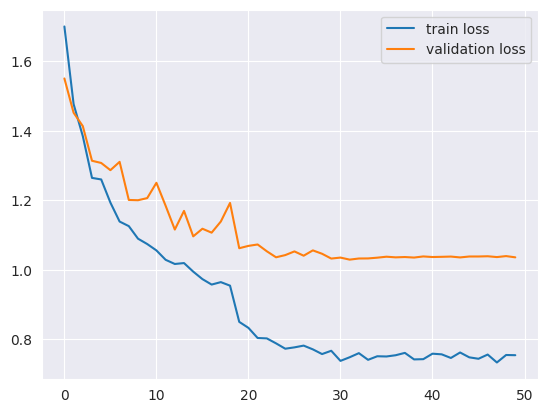

In [ ]:
# Visualize losses
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()

In [ ]:
# General Accuracy
def cal_accuracy(data_loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    accuracy = n_correct / n_total

    return accuracy


print(f"Train Accuracy: {cal_accuracy(train_loader):.4f}, Validation Accuracy: {cal_accuracy(val_loader):.4f}, Test Accuracy: {cal_accuracy(test_loader):.4f}")

Train Accuracy: 0.5426, Validation Accuracy: 0.5556, Test Accuracy: 0.5478


In [ ]:
# Classification Report
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        y_true_list.append(targets.cpu().numpy())
        y_pred_list.append(predictions.cpu().numpy())

# flatten data of batches into a 1-d list
y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.51      0.70      0.59       404
           1       0.44      0.08      0.14       201
           2       0.63      0.77      0.69       134
           3       0.50      0.79      0.61       112
           4       0.44      0.49      0.46        88
           5       0.58      0.70      0.64        54
           6       0.84      0.79      0.82       130
           7       0.13      0.03      0.04       111

    accuracy                           0.55      1234
   macro avg       0.51      0.54      0.50      1234
weighted avg       0.51      0.55      0.50      1234



In [ ]:
# Confusion Matrix

print(confusion_matrix(y_true_list, y_pred_list))

[[281  14  38  43   6   8   5   9]
 [145  17   2  12   1  12   2  10]
 [ 24   0 103   4   0   2   1   0]
 [  2   0   4  88  16   0   2   0]
 [ 18   2   5  10  43   2   7   1]
 [ 11   0   3   1   1  38   0   0]
 [  4   1   8   2  11   1 103   0]
 [ 63   5   1  15  20   2   2   3]]


# Inference

In [24]:
# Load Model
import torch
import torch.nn as nn


# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Instantiate the empty model
model = ClassificationCnn(num_class=8)

checkpoint_path = 'Retinal_Disease_ClassificationCnn.pth'

try:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("Model weights loaded successfully!")
except RuntimeError as e:
    print(f"Error loading weights: {e}")

# Move to device and set to Evaluate mode
model = model.to(device)
model.eval()

Model weights loaded successfully!


ClassificationCnn(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step 1: Upload a Retinal Image...


Saving 00001aa7.png to 00001aa7.png
✅ Loaded label_images.csv successfully.


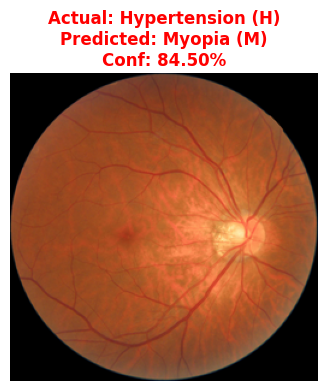

File: 00001aa7.png


In [37]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io
import pandas as pd
import os

to_name_map = {
    "['N']": "Normal (N)",
    "['D']": "Diabetes (D)",
    "['G']": "Glaucoma (G)",
    "['C']": "Cataract (C)",
    "['A']": "AMD (A)",
    "['H']": "Hypertension (H)",
    "['M']": "Myopia (M)",
    "['O']": "Other (O)"
}


class_names = ['AMD (A)', 'Cataract (C)', 'Diabetes (D)', 'Glaucoma (G)', 'Hypertension (H)', 'Myopia (M)', 'Normal (N)', 'Other (O)']

CSV_FILE_NAME = 'label_images.csv'

def predict_with_csv_verification(model, device):
    global CSV_FILE_NAME

    print("Step 1: Upload a Retinal Image...")
    uploaded_img = files.upload()

    if not os.path.exists(CSV_FILE_NAME):
        print(f"\n '{CSV_FILE_NAME}' not found.")
        print("Step 2: Please upload your CSV labels file...")
        uploaded_csv = files.upload()

        for filename, content in uploaded_csv.items():
            with open(filename, 'wb') as f:
                f.write(content)
            CSV_FILE_NAME = filename

    try:
        df = pd.read_csv(CSV_FILE_NAME)

        print(f"Loaded {CSV_FILE_NAME} successfully.")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        df = None

    for img_name, img_content in uploaded_img.items():

        inference_transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image = Image.open(io.BytesIO(img_content)).convert('RGB')
        input_tensor = inference_transforms(image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, pred_idx = torch.max(probs, 1)

        predicted_illness = class_names[pred_idx.item()]
        confidence_score = confidence.item() * 100

        actual_label = None
        if df is not None:

            row = df[df['images'] == img_name]

            if row.empty:
                name_no_ext = os.path.splitext(img_name)[0]
                row = df[df['images'].astype(str).str.contains(name_no_ext, regex=False)]

            if not row.empty:
                raw_label = str(row.iloc[0]['label']).strip()

                if raw_label in to_name_map:
                    actual_label = to_name_map[raw_label]
                else:
                    actual_label = raw_label


        title_text = f"Predicted: {predicted_illness}\nConf: {confidence_score:.2f}%"
        title_color = 'blue'
        status_msg = "Not found in CSV"

        if actual_label:
            if predicted_illness.lower() == actual_label.lower():
                title_color = 'green'
                status_msg = "Correct Diagnosis"
                title_text = f"Actual: {actual_label}\nPredicted: {predicted_illness}\nConf: {confidence_score:.2f}%"
            else:
                title_color = 'red'
                status_msg = "Incorrect Diagnosis"
                title_text = f"Actual: {actual_label}\nPredicted: {predicted_illness}\nConf: {confidence_score:.2f}%"

        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis('off')
        plt.title(title_text, color=title_color, fontweight='bold')
        plt.show()

        print(f"File: {img_name}")

predict_with_csv_verification(model, device)